## Equipo 2
Carlos Julian Herrera, A01114097 <br>
Ali Villegas, A01337596 <br>
Alfredo Quintero, A01337630 <br>

Las explicaciones del codigo estan comentadas dentro de cada funcion. <br>
De igual forma se hacen comentarios en lineas que son mas relevantes para el funcionamiento.


In [1]:
import heapq
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Helper functions and classes
class Vertex:
    def __init__(self,x_coord,y_coord):
        self.x=x_coord
        self.y=y_coord
        # De acuerdo con el algoritmo de Dijsktra la distancia al source inicialmente es infinita
        self.d=float('inf') 
        self.parent_x=None
        self.parent_y=None
        # Variable que indica que el nodo ya fue procesado (vertice y vecinos visitados)
        self.processed=False
        # Variable auxiliar para indicar donde esta el vertice en el min-heap
        self.index_in_queue=None

#Return neighbor directly above, below, right, and left
def get_neighbors(mat,r,c):
    shape=mat.shape
    neighbors=[]
    #ensure neighbors are within image boundaries
    if r > 0 and not mat[r-1][c].processed:
         neighbors.append(mat[r-1][c])
    if r < shape[0] - 1 and not mat[r+1][c].processed:
            neighbors.append(mat[r+1][c])
    if c > 0 and not mat[r][c-1].processed:
        neighbors.append(mat[r][c-1])
    if c < shape[1] - 1 and not mat[r][c+1].processed:
            neighbors.append(mat[r][c+1])
    return neighbors

def bubble_up(queue, index):
    '''Mueve un nodo hacia arriba en el indice especificado 
    hasta que el heap este reconstruido,
    luego de que se haya insertado un elemento
    '''
    if index <= 0:
        return queue
    p_index=(index-1)//2
    if queue[index].d < queue[p_index].d:
            queue[index], queue[p_index]=queue[p_index], queue[index]
            queue[index].index_in_queue=index
            queue[p_index].index_in_queue=p_index
            quque = bubble_up(queue, p_index)
    return queue

         
def bubble_down(queue, index):
    '''Mueve un nodo hacia abajo en el indice especificado 
    hasta que el heap este reconstruido,
    luego de que se haya borrado un elemento  
    '''
    length=len(queue)
    lc_index=2*index+1
    rc_index=lc_index+1
    if lc_index >= length:
        return queue
    if lc_index < length and rc_index >= length: #just left child
        if queue[index].d > queue[lc_index].d:
            queue[index], queue[lc_index]=queue[lc_index], queue[index]
            queue[index].index_in_queue=index
            queue[lc_index].index_in_queue=lc_index
            queue = bubble_down(queue, lc_index)
    else:
        small = lc_index
        if queue[lc_index].d > queue[rc_index].d:
            small = rc_index
        if queue[small].d < queue[index].d:
            queue[index],queue[small]=queue[small],queue[index]
            queue[index].index_in_queue=index
            queue[small].index_in_queue=small
            queue = bubble_down(queue, small)
    return queue

def get_distance(img,u,v):
    ''' Un vertice es representado por un pixel en la imagen.
    Para determinar la distancia de un vertice con otro,
    se toma la diferencia de los canales RGB.
    Como un pixel negro tiene un valor de 0 en todos sus canales,
    la diferencia entre un pixel negro y un pixel blanco va ser muy grande
    en comparacion a la de dos pixeles blancos
    '''
    return 0.1 + (float(img[v][0])-float(img[u][0]))**2+(float(img[v][1])-float(img[u][1]))**2+(float(img[v][2])-float(img[u][2]))**2

def drawPath(img,path, thickness=2):
    '''path is a list of (x,y) tuples'''
    x0,y0=path[0]
    for vertex in path[1:]:
        x1,y1=vertex
        cv2.line(img,(x0,y0),(x1,y1),(255,0,0),thickness)
        x0,y0=vertex

In [3]:
def find_shortest_path(img,src,dst):
    '''Encuentra el camino mas corto en un laberinto representado por un grafo.
    Donde cada pixel es un vertice, funciona sobre la premisa de
    que el color de los bordes sera muy distinto al color del laberinto.
    Porque la distancia de un vertice y otro se basa en la diferencia de los canales RGB
    '''
    pq=[] # Usa un min-heap para procesar las distancias menores
    source_x=src[0] 
    source_y=src[1]
    dest_x=dst[0]
    dest_y=dst[1]
    imagerows,imagecols=img.shape[0],img.shape[1]
    # Construye la matriz con los datos de OpenCV
    # Mapea los pixeles a los vertices del grafo
    matrix = np.full((imagerows, imagecols), None) #access by matrix[row][col]
    for r in range(imagerows):
        for c in range(imagecols):
            matrix[r][c]=Vertex(c,r)
            matrix[r][c].index_in_queue=len(pq)
            pq.append(matrix[r][c])
    # Inicializa la distancia del vertice inicial a 0 
    matrix[source_y][source_x].d=0
    # Contruye el min-heap con el primer elemnto siendo la fuente
    pq=bubble_up(pq, matrix[source_y][source_x].index_in_queue)
    
    # Implementacion de Dijkstra
    # Encontrara el camino mas corto del nodo inicial a todos los otros nodos
    while len(pq) > 0:
        u=pq[0] # Valor menor de nodos no procesados
        u.processed=True 
        pq[0]=pq[-1]
        pq[0].index_in_queue=0
        pq.pop()
        pq=bubble_down(pq,0)
        neighbors = get_neighbors(matrix,u.y,u.x)
        # Se construyen las aristas de cada vertice hacia cada uno de sus vecinos
        # Arriba, abajo, izquierda o derecha dependiendo de si esta las esquinas
        for v in neighbors:
            dist=get_distance(img,(u.y,u.x),(v.y,v.x))
            # Asignara la distancia de u a v, 
            # si la nueva distancia sera menor a la existente
            if u.d + dist < v.d:
                v.d = u.d+dist
                v.parent_x=u.x
                v.parent_y=u.y
                idx=v.index_in_queue
                pq=bubble_down(pq,idx)
                pq=bubble_up(pq,idx)

    # Contruye el camino que existe del nodo origen al nodo destino  
    path=[]
    iter_v=matrix[dest_y][dest_x]
    path.append((dest_x,dest_y))
    while(iter_v.y!=source_y or iter_v.x!=source_x):
        path.append((iter_v.x,iter_v.y))
        iter_v=matrix[iter_v.parent_y][iter_v.parent_x]

        
    path.append((source_x,source_y))
    return path

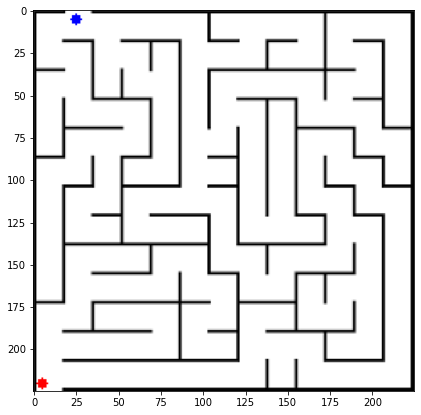

In [4]:
# Se usa OpenCV para leer y modificar las imagenes 
img = cv2.imread('maze.png') # read the image 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (25,5), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

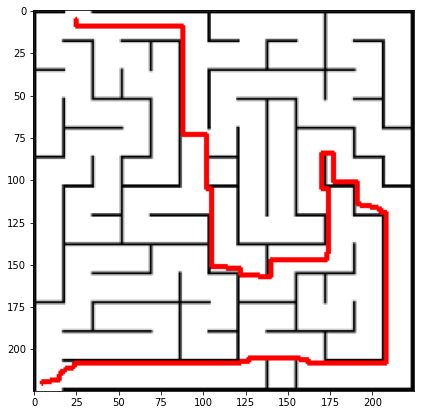

In [5]:
img = cv2.imread('maze.png') # read image
cv2.imwrite('maze-initial.png', img)
p = find_shortest_path(img, (25,5), (5,220))
# Tomando el camino mas corto de la fuente al destino, 
# se dibujan puntos en la imagen que representan nodos
drawPath(img,p)
cv2.imwrite('maze-solution.png', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()

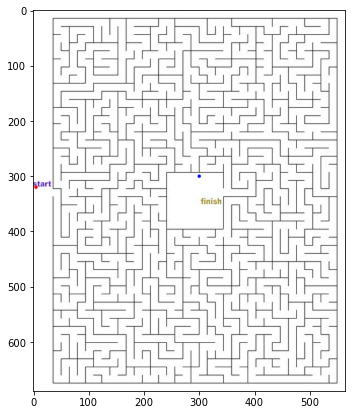

In [6]:
img = cv2.imread('maze5.jpg') # read the image 
cv2.circle(img,(5,320), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (300,300), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

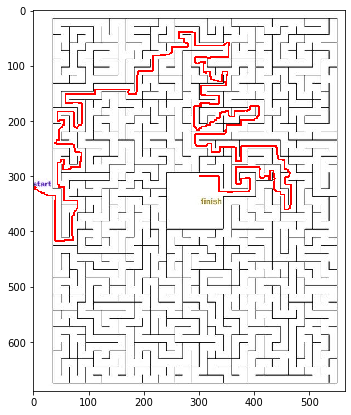

In [26]:
img = cv2.imread('maze5.jpg') # read image
cv2.imwrite('maze-initial5.jpg', img)
p = find_shortest_path(img, (300,300), (5,320))
drawPath(img,p)
cv2.imwrite('maze-solution5.jpg', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()